<a href="https://colab.research.google.com/github/ShaunakSen/Data-Science-and-Machine-Learning/blob/master/SmartSteelTech_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rough Approach

1. EDA
    - Explore how distribution of class labels change wrt each sensor
    - Corr bw sensor data
2. Baseline LogReg model
    - explore performance
    - wts of the features correspond to the importances?
    - https://machinelearningmastery.com/calculate-feature-importance-with-python/

3. Decision Tree model
    - feature importances

4. Idea 
    - what if we use a tree with only one feature at a time and analyze the accuracy
    - This is how DTs are constructed, we decide on the root node by checking which feature predicts best - we can use this same approach

4. SHAP on that DT
    - Global Importances
    - Local Importances
    - if we have instances that are more imp to us, we can look that the
    - features which explain those instances and put more wt on these features; SHAP allows us to do this
    - Also imagine if our prob were unbalanced and there are few values of one class. Now one feature may only be imp in predictions of that class. The default FI calculates how many times a feature is used as a split and this no will be low for that feature, but its very imp for that class

5. permutation importance

6. finally take a weighted rank

7. Also write what u can infer about the data

In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import itertools
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.utils import shuffle
%matplotlib inline

In [3]:
data = pd.read_csv(filepath_or_buffer='./task_data.csv')
data

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969
...,...,...,...,...,...,...,...,...,...,...,...,...
395,sample395,-1.0,0.433150,0.816109,0.452945,0.065469,0.237093,0.719321,0.577969,0.085598,0.357115,0.070060
396,sample396,-1.0,0.339346,0.914610,0.097827,0.077522,0.484140,0.690568,0.420054,0.482845,0.395148,0.438641
397,sample397,-1.0,0.320118,0.444951,0.401896,0.970993,0.960264,0.138345,0.354927,0.230749,0.204612,0.558889
398,sample398,-1.0,0.059132,0.337426,0.772847,0.099038,0.966042,0.975086,0.532891,0.035839,0.258723,0.709958


In [4]:
data.isnull().sum(axis=0)

sample index    0
class_label     0
sensor0         0
sensor1         0
sensor2         0
sensor3         0
sensor4         0
sensor5         0
sensor6         0
sensor7         0
sensor8         0
sensor9         0
dtype: int64

Good, so no NULL values

In [5]:
data.describe()

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000000,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,1.001252,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,-1.000000,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,-1.000000,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.000000,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,1.000000,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,1.000000,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


All features are in rane 0 -> 1, so they are quite normalized

In [6]:
data['class_label'].value_counts()

-1.0    200
 1.0    200
Name: class_label, dtype: int64

This is a perfectly balanced binary classification scenario

From an initial explorartion of the data it seems to be a monitoring system that might be designed to predict possible issues. We have the data of the sensor readings and the corresponding outcome in form of class labels
It is required to find which sensors are most important maybe because cost of installing such sensors is expensive or might lead to overheads and we would like to achieve the same predictive power through less sensors

Or it might simply be used as a dimensionality reduction technique to decrease model complexity, as simpler models are much less prone to overfitting

## Analysis 1 : How does the distrubution of class label changes wrt each feature

- For each feature (sensor), how is the distribution of values for the class label
- For each sensor we can plot the distribution for each class label in form of a pairwise boxplot to get a better understanding

In [7]:
def feature_distribution_per_class(data, features):
    """
    For each feature print out the distribution of that feature for each class
    """
    for fea_ in features:
        if fea_ in data.columns:
            display(data.groupby('class_label').aggregate({fea_: ['mean', min, max]} ))

    return

features = [f'sensor{i}' for i in range(10)]
feature_distribution_per_class(data, features)

sensor0                    
                 mean       min       max
class_label                              
-1.0         0.378135  0.007775  0.999476
 1.0         0.669187  0.017610  0.999476

sensor1                    
                 mean       min       max
class_label                              
-1.0         0.578911  0.004316  0.998680
 1.0         0.439535  0.003865  0.981556

sensor2                    
                 mean       min       max
class_label                              
-1.0         0.470101  0.004473  0.992963
 1.0         0.492376  0.013799  0.975777

sensor3                    
                 mean       min       max
class_label                              
-1.0         0.380815  0.001466  0.995119
 1.0         0.638689  0.014431  0.991156

sensor4                    
                 mean       min       max
class_label                              
-1.0         0.322972  0.000250  0.999412
 1.0         0.672778  0.002246  0.999412

sensor5                    
                 mean       min       max
class_label                              
-1.0         0.436673  0.000425  0.984338
 1.0         0.565457  0.002695  0.997367

sensor6                    
                 mean       min       max
class_label                              
-1.0         0.492627  0.248746  0.745404
 1.0         0.488333  0.000173  0.997141

sensor7                    
                 mean       min       max
class_label                              
-1.0         0.432786  0.003453  0.975558
 1.0         0.531957  0.003322  0.998230

sensor8                    
                 mean       min       max
class_label                              
-1.0         0.287406  0.003864  0.959601
 1.0         0.678239  0.003165  0.996098

sensor9                    
                 mean       min       max
class_label                              
-1.0         0.516104  0.007976  0.982287
 1.0         0.567762  0.000452  0.999465

At a glance there looks to be variability in all features for each class label

- For most features the avg value of that feature for class 1 is diffenet from that of class -1

- For sensor6, the mean is very similar, but again the min and max differ, so even this feature can be quite important

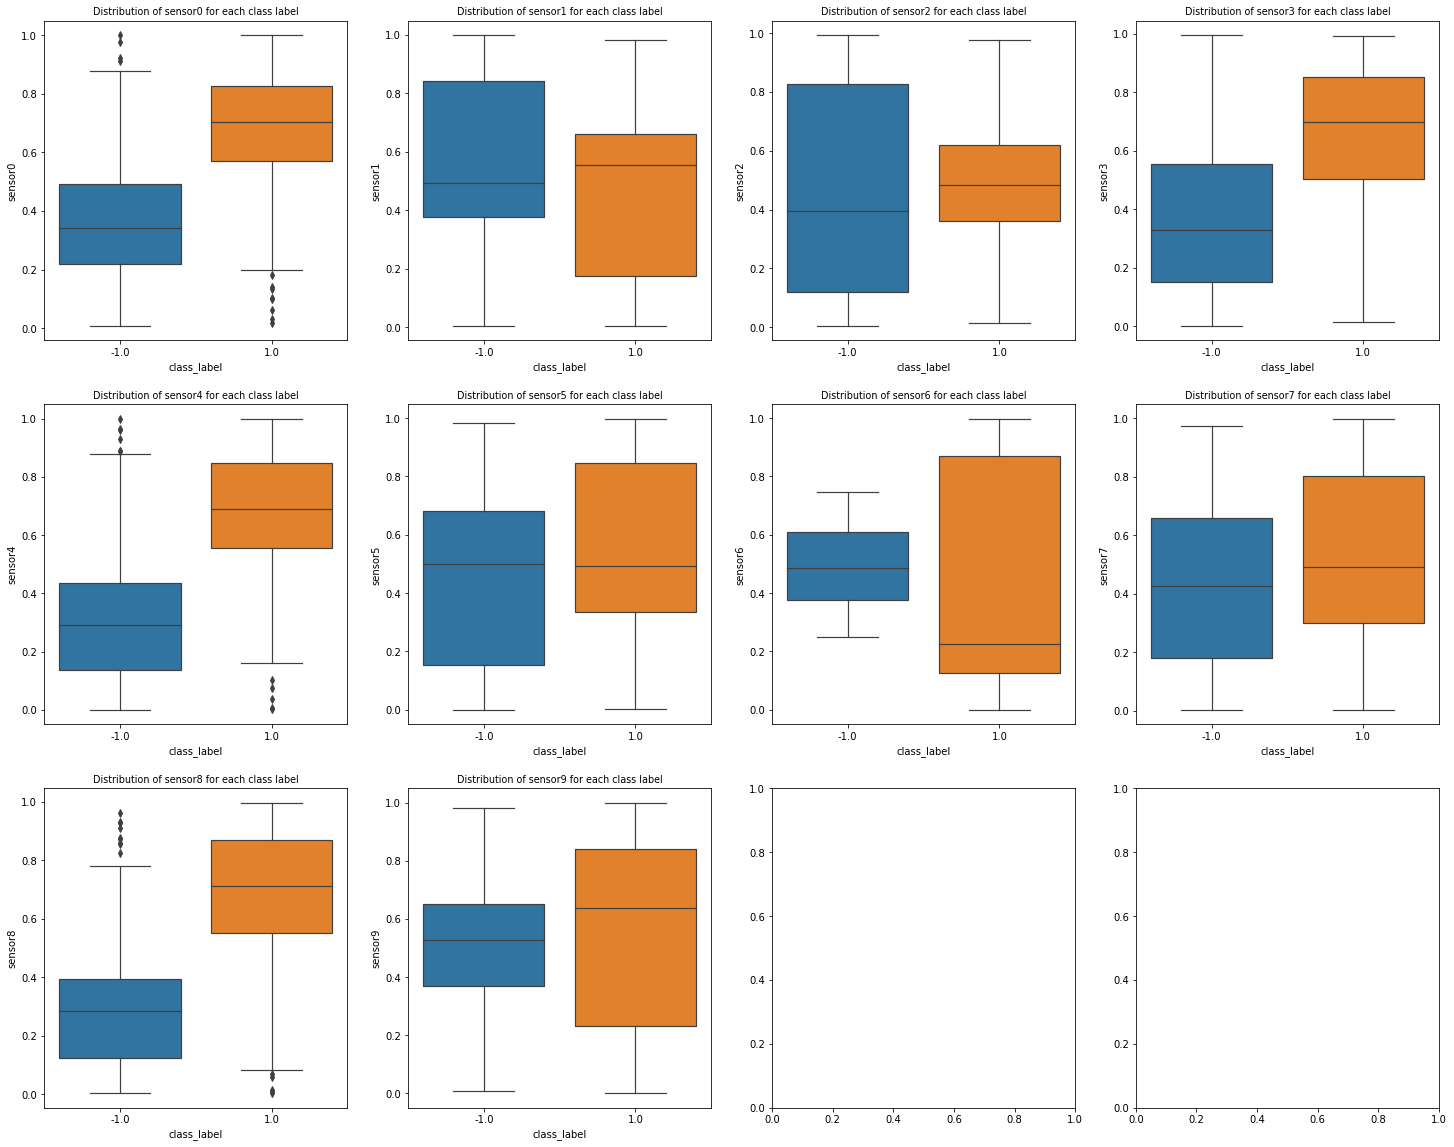

In [8]:
def plot_feature_distribution_per_class(data, features, ncols):
    """
    Plot the distribution for each feature wrt each label
    data: the input dataframe
    features: feature names to plot
    ncols: no of cols to use in the figure (rows get adjusted automatically)
    """
    fig, axes = plt.subplots(int(np.ceil(len(features)/ncols)), ncols, figsize=(25, 20))
    sns.set_context('paper')
    row_idx = -1
    for idx, fea_ in enumerate(features):
        if idx > ncols-1:
            col_idx = idx%ncols
        else:
            col_idx = idx
        if col_idx == 0:
            row_idx += 1
        sns.boxplot(ax=axes[row_idx, col_idx], x='class_label', y=fea_, data=data)
        axes[row_idx, col_idx].set_title(f'Distribution of {fea_} for each class label')

    return


plot_feature_distribution_per_class(data, features, 4)

- we can see from the plots as well that the distributions differ significantly within classes for each of the features
- from this, we conclude that __we cannot yet assume that any feature is not important__

## Analysis 2: Analyze correlations within features

- first we can generate plots taking 2 features at a time to understand how they are related to each other

- if the trend seems linear we can apply Person's correlation (we already know that each feature is numeric)

- Since there are 10 features we will have `10C2 = 45` possible combinations of features


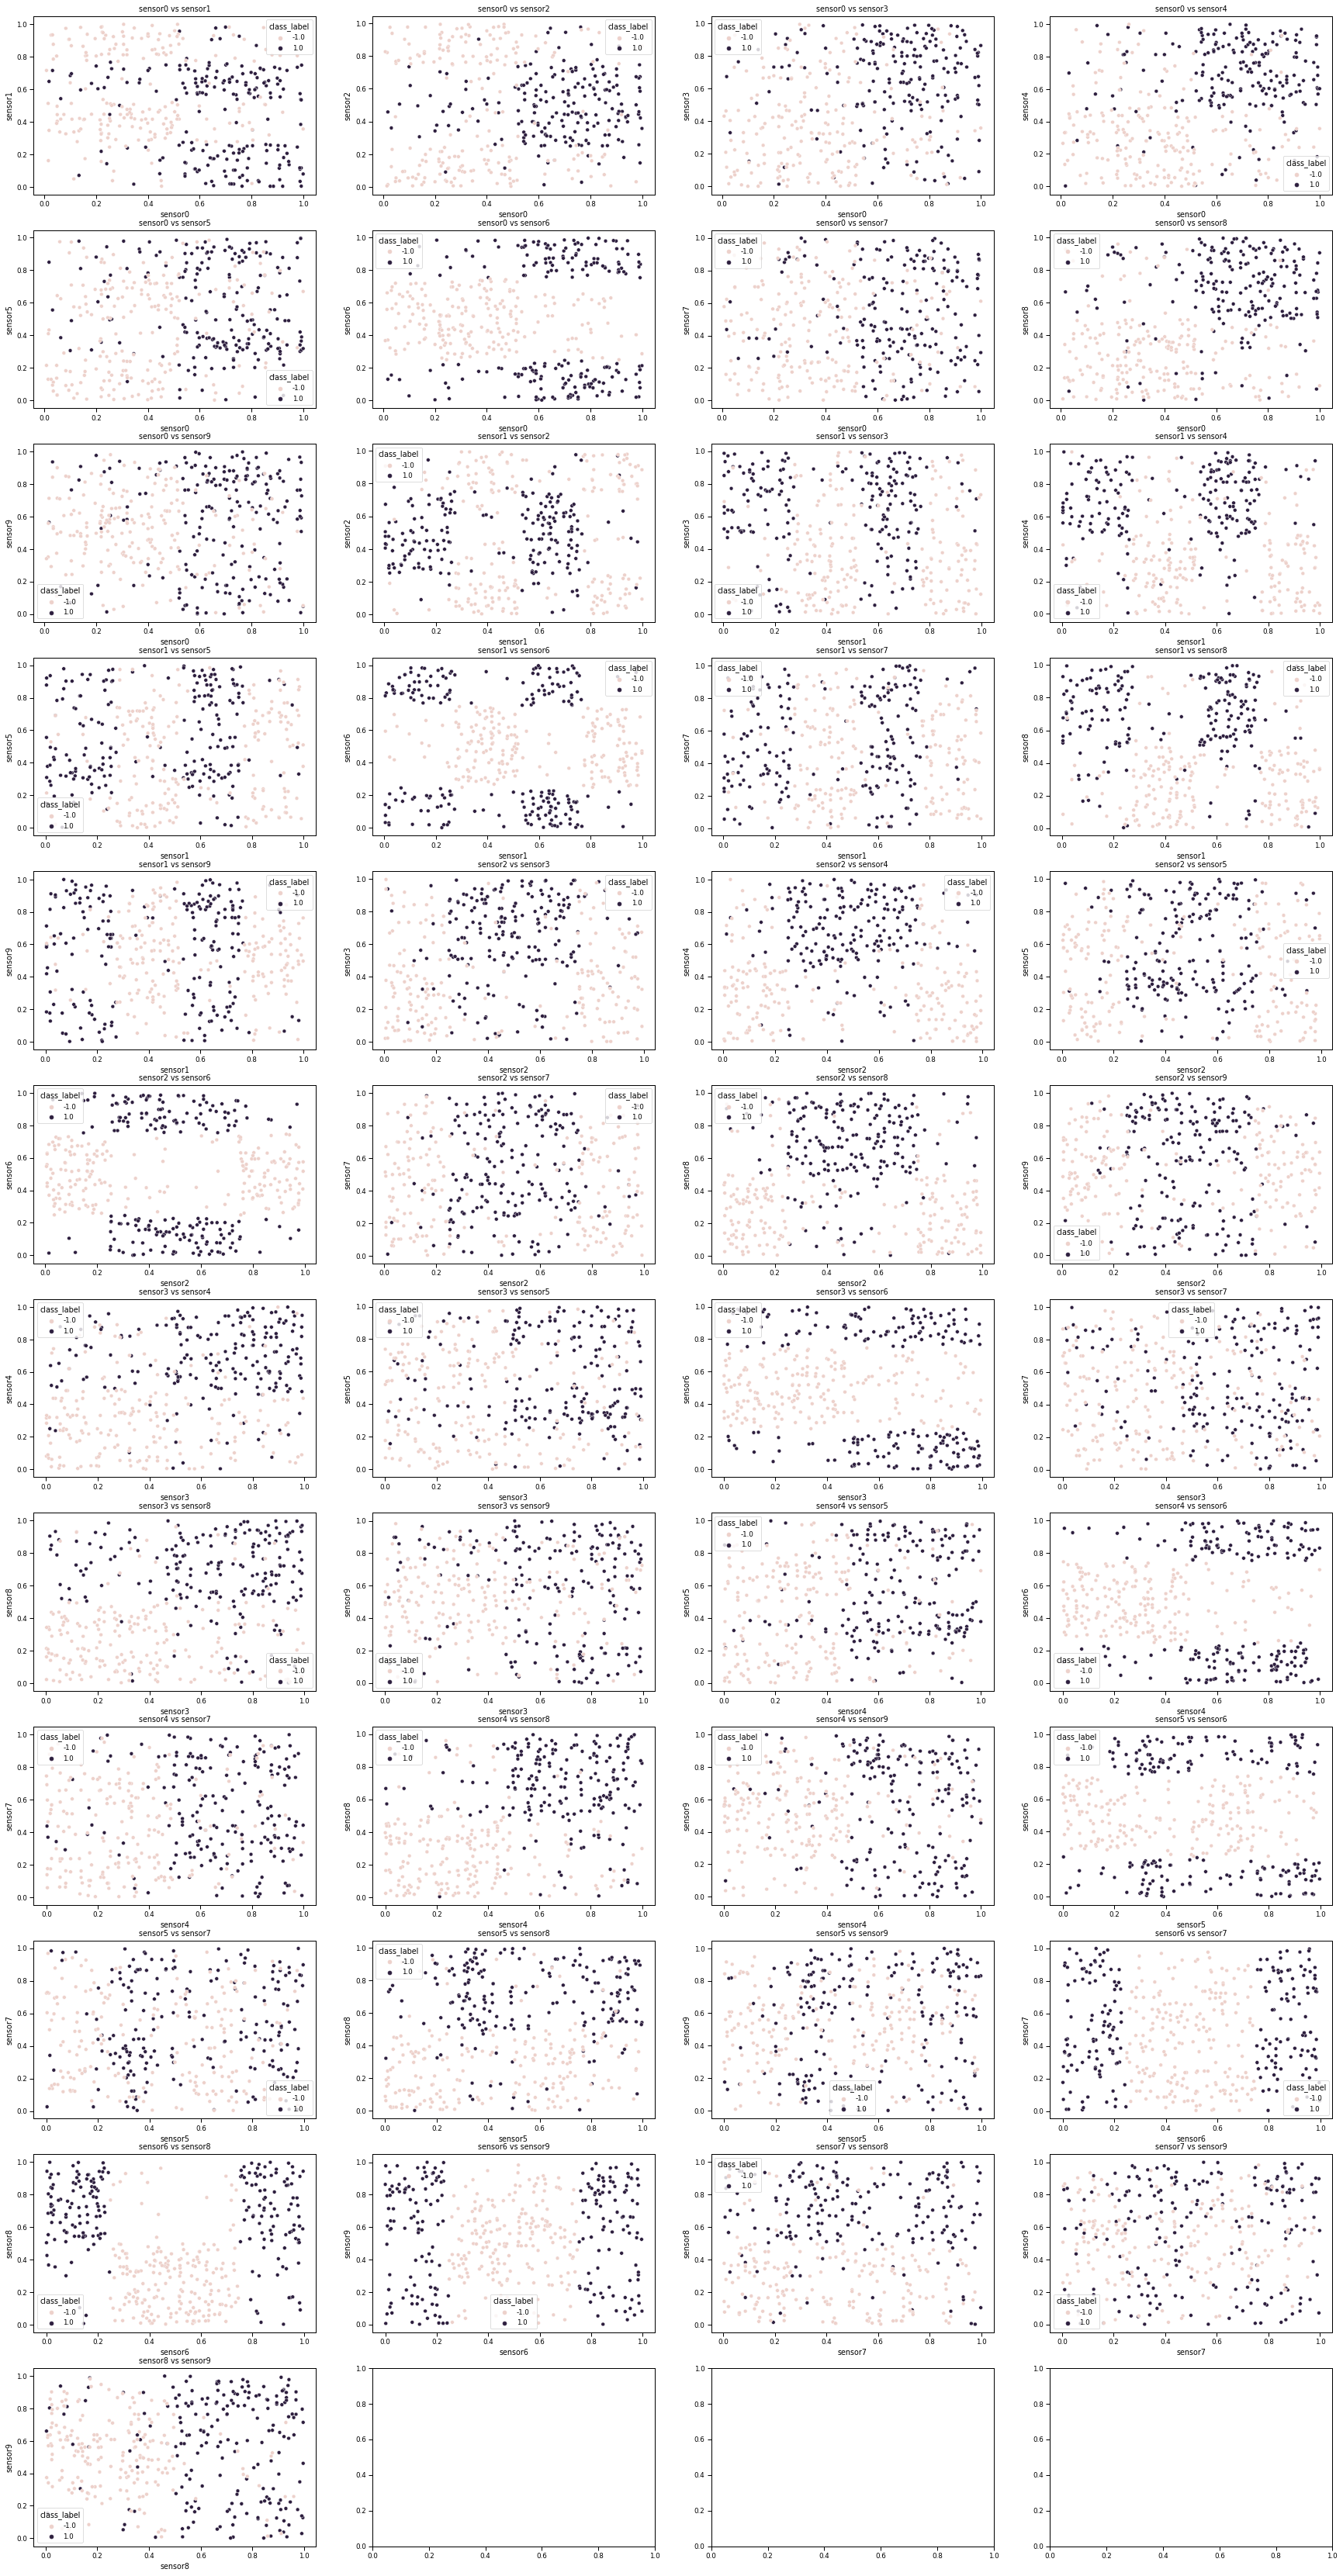

In [9]:
def visualize_pairwise_feature_interactions(data, features, ncols):

    all_feature_combos = list(itertools.combinations(features,2))

    fig, axes = plt.subplots(int(np.ceil(len(all_feature_combos)/ncols)), ncols, figsize=(30, 60))
    sns.set_context('paper')
    row_idx = -1
    for idx, (fea_1, fea_2) in enumerate(all_feature_combos):
        if idx > ncols-1:
            col_idx = idx%ncols
        else:
            col_idx = idx
        if col_idx == 0:
            row_idx += 1
        sns.scatterplot(ax=axes[row_idx, col_idx], x=fea_1, y=fea_2, hue='class_label', data=data)
        axes[row_idx, col_idx].set_title(f'{fea_1} vs {fea_2}')

    return

visualize_pairwise_feature_interactions(data, features, 4)

We observe some interesting patterns from the above plot:

- there seems to be weak to no correlations between features

- by coloring the class labels we can identify how the class labels depend on the interaction of features

- In many cases there appears as if we can construct linear decision boundaries to determine each class label
    - For example:
    - In the sensor0 vs sensor6 plot we can draw decison boundaries as shown to separate out the 2 classes
    - ![](https://i.imgur.com/8IpdgV6.png)

    - we can roughly see that the approximate rule is: when `0 <= sensor6 < 0.2 OR 0.8 < sensor6 < 1 -> class 1 else class 0 `

    - The decision boundaries can look slightly more complex as shown below:
    - ![](https://i.imgur.com/EZHeNVp.png)
    - The boundary is just for illustration purpose and not a pratical one but we can see that based on various combinations of the features we can separate out the classes

    - These linear boundaries look very similar to the ones construced by Decision Trees and tree-based algorithm looks suitable for such a problem. Below are some example decision boundaries of DTs vs KNNs

    ![](https://shapeofdata.files.wordpress.com/2013/07/dtree2.png)

    ![](https://shapeofdata.files.wordpress.com/2013/03/knn1.png)

    Source: https://shapeofdata.wordpress.com/2013/07/02/decision-trees/

    - Also decision trees give us the ability to compute feature importances quite easily by computing the total information the feature provides while building the tree


This is why we will place a lage emphasis on Decision Trees to determine feature importance

We can use gradient boosting algorithms and ensemble learning techniques like XGBoost, LightGBM, Random Forests as well, but since our focus here is to determine the feature ranks and not build a great ML model, we will focus on techniques for computing Feature importance more


## Approach 1: Using Decision Trees for each feature

The idea here is to:

1. Consider each feature as a stand-alone feature in the dataset
2. Construct a decision tree using that feature
3. Compute the accuracy (training accuracy) for the decision tree
    - this indicates how good that feature alone is in separating the classes
    - since we are dealing with a balance binary classification problem, accuracy is a suitable metric here
4. Rank the features based on this accuracy
5. the benefit of this approach is that we rank each feature individually without the influence/interactions with the other features


In [10]:
### convert the class labels to be 0 and 1 for compatiblity with sklearn
data['class_label'] = [1 if label_==1 else 0 for label_ in data['class_label']]

In [11]:
data

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969
...,...,...,...,...,...,...,...,...,...,...,...,...
395,sample395,0,0.433150,0.816109,0.452945,0.065469,0.237093,0.719321,0.577969,0.085598,0.357115,0.070060
396,sample396,0,0.339346,0.914610,0.097827,0.077522,0.484140,0.690568,0.420054,0.482845,0.395148,0.438641
397,sample397,0,0.320118,0.444951,0.401896,0.970993,0.960264,0.138345,0.354927,0.230749,0.204612,0.558889
398,sample398,0,0.059132,0.337426,0.772847,0.099038,0.966042,0.975086,0.532891,0.035839,0.258723,0.709958


In [12]:
def DT_for_each_feature(data, features):
    """
    For each featute train a DT and compute accuracy and F1 score
    Store the result in results_data and return the list
    """

    results_data = []

    for fea_ in features:
        print (f'Training DT for {fea_}')
        X, y = data.loc[:, [fea_]], data['class_label']
        X, y = shuffle(X, y)
        clf = DecisionTreeClassifier(criterion='gini')
        clf.fit(X, y)
        ### get predictions on the training data
        y_pred = clf.predict(X)
        acc_ = accuracy_score(y_true=y, y_pred=y_pred)
        f1_ = f1_score(y_true=y, y_pred=y_pred)
        results_data.append({'feature': fea_, 'accuracy': acc_, 'f1_score': f1_})  
    return results_data

all_features = [f'sensor{i}' for i in range(10)]

results_data = DT_for_each_feature(data, all_features)



Training DT for sensor0
Training DT for sensor1
Training DT for sensor2
Training DT for sensor3
Training DT for sensor4
Training DT for sensor5
Training DT for sensor6
Training DT for sensor7
Training DT for sensor8
Training DT for sensor9


In [14]:
### compute feature ranks for each F1 and accuracy
feature_rank_f1 = [item['feature'] for item in sorted(results_data, key=lambda res_: res_['f1_score'], reverse=True)]
feature_rank_acc = [item['feature'] for item in sorted(results_data, key=lambda res_: res_['accuracy'], reverse=True)]

print (feature_rank_f1)
print (feature_rank_acc)

### check if both are equal
print (feature_rank_acc == feature_rank_f1)

['sensor6', 'sensor1', 'sensor8', 'sensor2', 'sensor4', 'sensor5', 'sensor0', 'sensor7', 'sensor9', 'sensor3']
['sensor6', 'sensor1', 'sensor8', 'sensor2', 'sensor4', 'sensor5', 'sensor0', 'sensor7', 'sensor9', 'sensor3']
True


In [15]:
### finalize feature rank for method 1
feature_rank_method1 = feature_rank_acc

## Approach 2 : Use feature importance of DTs

The idea behind this approach is that we can use the entire data to fit a Decision Tree and check the training accuracy

If the accuracy is good we use the inbuilt `feature_importances_` paarmeter to get the feature importances of each feature

This is not an independent metric; the values of feature importances depends on the other features, but still gives us a very good idea of the ranks of features

The fature importance method in DT is basically the decrease in node impurity (Gini impurity) for weighted by the number of samples at the node at which the split is calculated. Gini impurity is high when the split does a bad job at classifying the samples (when the nodes are impure - similar number of saamples of both classes exist). So the `feature_importances_` gives a good estimate of how good each feature is in separating the class labels (https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)



In [16]:
all_features = [f'sensor{i}' for i in range(10)] ## get all features
X, y = data.loc[:, all_features], data['class_label'] ## build training data and labels

X, y = shuffle(X, y)

print (X.shape, y.shape)

(400, 10) (400,)


We do not really need to consider a test set here as the ML model is not to be deployed

We are just using it to rank features.

So at every step we are fitting the entire data to train our models

In [17]:
clf = DecisionTreeClassifier() ### build a model with default parameters
clf.fit(X, y) ### train it on the data

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [18]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

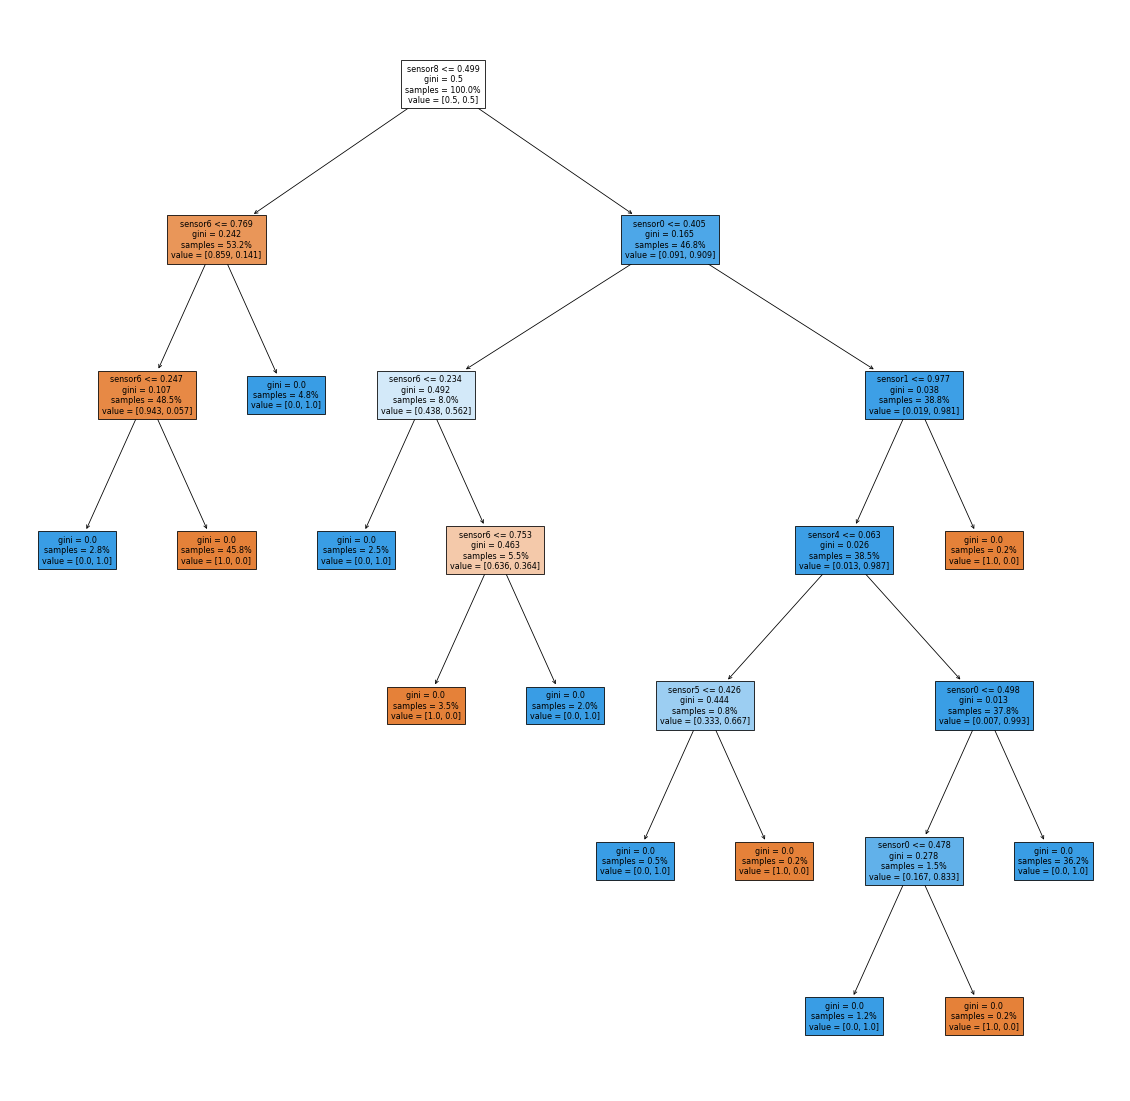

In [19]:
### plot the tree
plt.figure(figsize=(20,20))  # set plot size (denoted in inches)

plot_tree(clf, feature_names=list(X.columns), filled=True, proportion=True, fontsize=8);

In [20]:
### check accuracy and f1 score

y_pred = clf.predict(X)

print (accuracy_score(y_true=y, y_pred=y_pred), f1_score(y_true=y, y_pred=y_pred))

1.0 1.0


In [21]:
### the feature importances
clf.feature_importances_

array([0.05630987, 0.0096791 , 0.        , 0.        , 0.00313982,
       0.00666667, 0.33649648, 0.        , 0.58770807, 0.        ])

In [22]:
feature_importance_indices = np.argsort(-clf.feature_importances_) ### sort by importance descending and get the indices

In [23]:
feature_rank_method2 = [all_features[idx] for idx in feature_importance_indices]

feature_rank_method2

['sensor8',
 'sensor6',
 'sensor0',
 'sensor1',
 'sensor5',
 'sensor4',
 'sensor2',
 'sensor3',
 'sensor7',
 'sensor9']

In [24]:
feature_rank_method1

['sensor6',
 'sensor1',
 'sensor8',
 'sensor2',
 'sensor4',
 'sensor5',
 'sensor0',
 'sensor7',
 'sensor9',
 'sensor3']

The ranks obtained from this method are a bit different from the previous method

This is to be expected as this method considers all features together and not each of them independently

In [25]:
clf.get_depth()

6

The max depth of 6 indicates that it is not an overly-complex model

## Approach 3 : Logistic Regression

Even though we decided tree based models would do a good job at separating the classes, linear models often work very well and once we have a fitted Logistic Regression model, we can extract the weights. When the weight is positive that means that the feature that predicts class 1, whereas the negative weights indicate a feature that predicts class 0. (https://machinelearningmastery.com/calculate-feature-importance-with-python/)

We have considered Logistic Regression as we plan to assign weights to each method for ranking fetaures
As we believe that Logistic Regression might not be a good model for this dataset, we can always assign it a lower weight compared to other methods



Let us first fit a Logistic Regression model with the deault parameters on the full data and check the training accuracy

In [26]:
X, y = shuffle(X, y)
model = LogisticRegression()
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
model.coef_

array([[ 2.72286027, -1.2532217 ,  0.57179251,  2.12781977,  3.41135445,
         0.56255446,  0.40970685,  1.20645866,  4.06813204,  0.9837041 ]])

In [28]:
model.score(X, y)

0.935

The training accuracy is 93.5%, considerably lower than our DT model, which is expected. We can get the coefficients and these are the feature importances for the model

We can sort them and get a feature rank list

In [29]:
coef_ranks = np.argsort(-np.absolute(model.coef_[0])) ### sort weights desc and get indices

In [31]:
feature_rank_method3_1 = [all_features[idx] for idx in coef_ranks]
print (feature_rank_method3_1)

['sensor8', 'sensor4', 'sensor0', 'sensor3', 'sensor1', 'sensor7', 'sensor9', 'sensor2', 'sensor5', 'sensor6']


### Grid Search to improve results

We use grid search to try and improve the model's accuracy

Again, our focus is not to try and find a great model but simply rank the features, so we will only be performing a couple of experiments


In [32]:
### build the grid as a set of params we want to search
param_grid = [
              {
                'solver': ['lbfs', 'newton-cg', 'sag'],
                'penalty': ['l2'],
                'C': [0.001, 0.01, 1, 10, 100],
                'tol': [1e-3, 1e-2, 1e-1, 0, 1e+1]
              },
              {
                'solver': ['liblinear'],
                'penalty': ['l1','l2'],
                'C': [0.001, 0.01, 1, 10, 100],
                'tol': [1e-3, 1e-2, 1e-1, 0, 1e+1]
              }
]


We do not want any cross-validation, we want to use our whole training data for each parameter combination

In [33]:
cv = [(slice(None), slice(None))] ### credits: https://www.semicolonworld.com/question/59618/scikit-learn-gridsearchcv-without-cross-validation-unsupervised-learning

In [34]:
### create a GridSearchCV obj with the LogReg model and the parameter grid specidfied
### njobs=-1 to use all CPU cores, verbose=3 to print out info and scoring metric is accuracy
X, y = shuffle(X, y)
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, verbose=3, n_jobs=-1, cv=cv, scoring='accuracy')
grid.fit(X, y)

Fitting 1 folds for each of 125 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    2.0s finished


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 1, 10, 100], 'penalty': ['l2'],
                          'solver': ['lbfs', 'newton-cg', 'sag'],
                          'tol': [0.001, 0.01, 0.1, 0, 10.0]},
                         {'C': [0.001, 0.01, 1, 10, 100],
                          

In [35]:
print (grid.best_params_)

{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.1}


In [36]:
print (grid.best_score_)

0.9475


In [37]:
### verify the accuracy
y_pred = grid.predict(X)
print(accuracy_score(y, y_pred))

0.9475


Higher values of C and tol from default seems to give better results, we can futher restrict the search around these values

In [38]:
param_grid = [
              {
                'solver': [ 'newton-cg'],
                'penalty': ['l2'],
                'C': [50, 100, 200, 500, 700],
                'tol': [0.1, 0.3, 0.5, 0.7]
              }
]
X, y = shuffle(X, y)
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, verbose=3, n_jobs=-1, cv=cv, scoring='accuracy')
grid.fit(X, y)
print (grid.best_score_)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
0.9475


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


In [39]:
print (grid.best_params_)

{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.1}


These are the smae parameters as before, looks like we have a decent model now

In [40]:
better_LogReg_model = grid.best_estimator_ ### get the best estimator (best model)
X, y = shuffle(X, y) ### shuffle the data
better_LogReg_model.fit(X, y) ### fit the model
better_LogReg_model.score(X, y) ### compute accuracy

0.9475

In [42]:
### get the coeff values as feature importances
coef_ranks = np.argsort(-np.absolute(better_LogReg_model.coef_[0])) ### sort desc and get indices
feature_rank_method3_2 = [all_features[idx] for idx in coef_ranks]
print (feature_rank_method3_2)

['sensor8', 'sensor4', 'sensor0', 'sensor3', 'sensor1', 'sensor7', 'sensor9', 'sensor2', 'sensor6', 'sensor5']


In [44]:
print (feature_rank_method3_1)

['sensor8', 'sensor4', 'sensor0', 'sensor3', 'sensor1', 'sensor7', 'sensor9', 'sensor2', 'sensor5', 'sensor6']


All are same except sensor6 and sensor5 have ranks intercahanged

## Approach 4 : Using Shapely values

Shapely value is a concept inspired by Game Theory and in Machine Learning, it is mainly used to explain black box models

Say for a particular instance, our model has predicted a class of -1. Now there are 10 features - how has each of those features contributed to the prediction?

Shapely values (or SHAP) allow us to explain a prediction at an instance level. Lets say we are considering the ith instance in the data. So if the probability for class 1 = 0.9 and the average probability is around 0.5 (if we were simply guessing we would assign 0.5 as the probability), then the features together increase the probability by 0.9-0.5=0.4

The impacts of each of the features (in terms of probablity) might be `[0.3 -0.1 0.2 -0.1 -0.3 0.5 -0.3 -0.2 0.4]` - notice that the sum of these is 0.4 -   these values indicate how much each sesnor value contributes to the final probability - here as the SHAP value for sensor1 = 0.3 and say the ith fetaure value for sensor3 = 0.9 - this implies that the sensor value of 0.9 led to an increase in probaility by 0.3 for that instance to be of class 1

#### SHAP values as feature importance indicators

SHAP values can be used to estimate fetaure importances. As for each row we get what the individual impacts for the feature are in the prediction, we can simply aggregate the SHAP values for any slice of data we want and the aggregated measures for the SHAP values for a feature indicate the importance for that feature for the particular data slice (https://christophm.github.io/interpretable-ml-book/shap.html#shap-feature-importance)




In [45]:
### shuffle the data before training
X, y = shuffle(X, y)
print (X.shape, y.shape)

(400, 10) (400,)


In [46]:
### train a DecisionTreeClassifier model on the data similar to previous approach (limiting the max_depth for less overfitting)
model = DecisionTreeClassifier(max_depth=4)
model.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [47]:
model.score(X, y)

0.995

In [48]:
model.get_depth()

4

In [49]:
### create a SHAP tree explainer object and get the expected value
explainer = shap.TreeExplainer(model=model, feature_perturbation='interventional', model_output='probability', data=X)
explainer_expected_value = explainer.expected_value
print (explainer_expected_value)

[0.47598234 0.52401766]


We have 2 elements in `explainer_expected_value` deonoting the base value of each class outputs 

The expected value for eac class is close to 0.5 which is expected

In [50]:
### get the SHAP values; check_additivity basically checks that `shap_values + expected_value == prediction` for each instance
shap_values = explainer.shap_values(X=X, check_additivity=True)

In [51]:
len(shap_values)

2

The `shap_values[0]` are explanations with respect to the negative class, while `shap_values[1]` are explanations with respect to the positive class.

Each of these are numpy arrays with shape (400, 10) : the importances of each fetaure for each instance

In [52]:
### check shape

shap_values[0].shape, shap_values[1].shape

((400, 10), (400, 10))

In [53]:
### get the model predictions
y_pred = model.predict_proba(X)

Let us take a random sample and see how SHAP explains the prediction

Let us consider the 34th sample

In [54]:
shap_values[0][33].shape, shap_values[1][33].shape

((10,), (10,))

In [55]:
print(y_pred[33]) ### prob values for each class for this sample

y_pred_cls = np.argmax(y_pred[33]) ### get the predicted class

print (y_pred_cls)

[0.00662252 0.99337748]
1


Here the prediction is for the first class

So `expected_value_for_first_class + sum(SHAP values for 1st class for 34th instance) == probability for predicted class`

In [56]:
shap_values[y_pred_cls][33].sum() + explainer_expected_value[y_pred_cls]

0.9933774964735076

In [57]:
def check_and_build_shap(y_pred, shap_values, expected_values):
    """
    1. Checks the condition for expected_value + SHAP values == prediction
    2. Stores the shap values for the predicted class in op_SHAP
    """
    op_SHAP = [] ### list to store SHAP values of shape (num_instances, num_features) : the SHAP values for the predicted class for each instance

    y_pred_classes = np.argmax(y_pred, axis=1)  ### get the predicted class (idx with max prob)

    for idx, pred_class in enumerate(y_pred_classes): ### idx is the instance index
        shap_ = shap_values[pred_class][idx, :] ### shap values for the predicted class
        prob_ = y_pred[idx][pred_class] ### the predicted probability
        op_SHAP.append(shap_) ### append it to op_SHAP
        assert np.absolute(shap_.sum() + explainer_expected_value[pred_class] - prob_ ) < 0.001  ### the expected_value + SHAP values - prediction should be close to 0

    return np.array(op_SHAP)

op_SHAP = check_and_build_shap(y_pred, shap_values, explainer_expected_value)

In [58]:
op_SHAP.shape

(400, 10)

Now that we have extracted the SHAP values we can consider them to be good indicators for Fetaure Importance

For each feature we compute:

1. Mean SHAP
2. Mean absolute SHAP
3. MAX absolute SHAP


In [59]:
def compute_feature_statistics(SHAP_values, feature_names):
    """
    For each feature we compute:

    1. Mean SHAP
    2. Mean absolute SHAP
    3. MAX absolute SHAP
    """

    feature_stats = {
        'feature':[],
        'MEAN FI': [],
        'MEAN ABS FI': [],
        'MAX ABS FI': []
    }

    for idx, fea_ in enumerate(feature_names):
        fea_SHAP = SHAP_values[:, idx]
        MEAN_SHAP, MEAN_Abs_SHAP, MAX_abs_SHAP = np.mean(fea_SHAP), np.mean(np.absolute(fea_SHAP)), np.max(np.absolute(fea_SHAP))
        feature_stats['feature'].append(fea_)
        feature_stats['MEAN FI'].append(MEAN_SHAP)
        feature_stats['MEAN ABS FI'].append(MEAN_Abs_SHAP)
        feature_stats['MAX ABS FI'].append(MAX_abs_SHAP)

    return feature_stats

all_features = [f'sensor{i}' for i in range(10)]
feature_stats = compute_feature_statistics(op_SHAP, all_features)

In [60]:
feature_stats = pd.DataFrame(feature_stats)
feature_stats

,feature,MEAN FI,MEAN ABS FI,MAX ABS FI
0,sensor0,0.041659,0.054984,0.309378
1,sensor1,0.008885,0.009973,0.638595
2,sensor2,0.000000,0.000000,0.000000
3,sensor3,0.000000,0.000000,0.000000
4,sensor4,0.007469,0.012254,0.199566
5,sensor5,0.000000,0.000000,0.000000
6,sensor6,0.324146,0.324763,0.485000
7,sensor7,0.000000,0.000000,0.000000
8,sensor8,0.112600,0.121537,0.360887
9,sensor9,0.000000,0.000000,0.000000


The columns that are of primary interest for our use case are:

- MEAN ABS FI : on an average how important is that feature 
- MAX ABS FI: what is the maximum importance for that feature across all rows? If this is 0, this implies that the feature is __not at all important in any of the predictions__


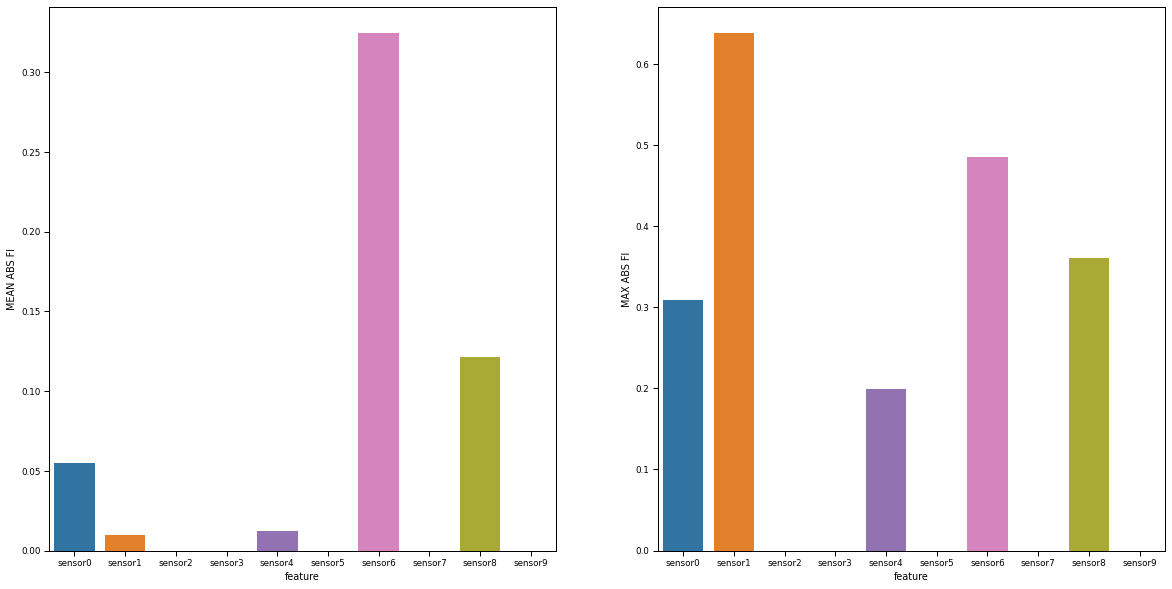

In [61]:
def plot_FI(feature_stats):
    

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    sns.set_context('notebook')
    
    sns.barplot(ax=axes[0], x='feature', y='MEAN ABS FI', data=feature_stats)
    sns.barplot(ax=axes[1], x='feature', y='MAX ABS FI', data=feature_stats)


plot_FI(feature_stats)

In [62]:
### fetaure rank by MAX abs SHAP
feature_rank_method4 = [fea_ for fea_ in feature_stats.sort_values(by='MAX ABS FI', ascending=False)['feature']]
feature_rank_method4

['sensor1',
 'sensor6',
 'sensor8',
 'sensor0',
 'sensor4',
 'sensor2',
 'sensor3',
 'sensor5',
 'sensor7',
 'sensor9']

## Approach 5: Permutation importance

The basic idea behind permuation importance is to fit a model on the dataset. The each feature is scrambed (permutated) and the change in accuracy is noted. If the change is major, this imples that the feature is important. We repeat this process multiple times and obtain a mean improtance score for each feature
- https://scikit-learn.org/stable/modules/permutation_importance.html

For thsis we have used the same DT model as SHAP analysis with amx_depth=4

In [63]:
from sklearn.inspection import permutation_importance


In [64]:
X, y = shuffle(X, y)

In [65]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [66]:
model.score(X, y)

0.995

In [67]:
### runpermutation importance for 20 runs for the DT model
inspection_obj = permutation_importance(estimator=model, X=X, y=y, scoring='accuracy', n_repeats=20, n_jobs=-1, random_state=123)

In [68]:
inspection_obj

{'importances': array([[0.02  , 0.025 , 0.0175, 0.0175, 0.015 , 0.0225, 0.0275, 0.025 ,
         0.0275, 0.0175, 0.0175, 0.015 , 0.0225, 0.0175, 0.03  , 0.015 ,
         0.025 , 0.02  , 0.0225, 0.0225],
        [0.01  , 0.0075, 0.01  , 0.0125, 0.0075, 0.0125, 0.015 , 0.0075,
         0.0175, 0.01  , 0.0075, 0.01  , 0.01  , 0.0075, 0.01  , 0.01  ,
         0.0075, 0.0075, 0.0075, 0.01  ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.  

In [69]:
## mean FI
permutation_FI = inspection_obj.importances_mean

In [70]:
permutation_FI

array([0.021125, 0.009875, 0.      , 0.      , 0.      , 0.      ,
       0.296375, 0.      , 0.09875 , 0.      ])

In [71]:
feature_importance_indices = np.argsort(-permutation_FI) ### sort desc and get indices

feature_importance_indices

array([6, 8, 0, 1, 2, 3, 4, 5, 7, 9])

In [72]:
all_features

['sensor0',
 'sensor1',
 'sensor2',
 'sensor3',
 'sensor4',
 'sensor5',
 'sensor6',
 'sensor7',
 'sensor8',
 'sensor9']

In [73]:
feature_rank_method5 = [all_features[idx] for idx in feature_importance_indices]  ### get the ranks

feature_rank_method5

['sensor6',
 'sensor8',
 'sensor0',
 'sensor1',
 'sensor2',
 'sensor3',
 'sensor4',
 'sensor5',
 'sensor7',
 'sensor9']

## Compare all the methods

In [75]:
def consolidate_feature_ranks(ranks_from_all_methods, method_names):
    """
    Consolidate teh feature ranks into one df 
    For each method, store ranks of all features
    """
    results_data = {
        'feature': [],
        'rank': [],
        'method': []
    }
    all_features = [f'sensor{i}' for i in range(10)]
    
    for idx, method_ in enumerate(method_names):
        ranks = ranks_from_all_methods[idx]
        for fea_ in all_features:
            results_data['feature'].append(fea_)
            fea_rank_ = ranks.index(fea_)
            results_data['rank'].append(fea_rank_)
            results_data['method'].append(method_)
    return results_data

method_names =  ['Separate DT', 'Single DT', 'LogReg1', 'LogReg2', 'SHAP', 'PI']
all_feature_ranks = consolidate_feature_ranks([feature_rank_method1,feature_rank_method2,feature_rank_method3_1,feature_rank_method3_2,feature_rank_method4,feature_rank_method5],method_names)

In [76]:
all_feature_ranks = pd.DataFrame(all_feature_ranks)
all_feature_ranks

,feature,rank,method
0,sensor0,6,Separate DT
1,sensor1,1,Separate DT
2,sensor2,3,Separate DT
3,sensor3,9,Separate DT
4,sensor4,4,Separate DT
5,sensor5,5,Separate DT
6,sensor6,0,Separate DT
7,sensor7,7,Separate DT
8,sensor8,2,Separate DT
9,sensor9,8,Separate DT


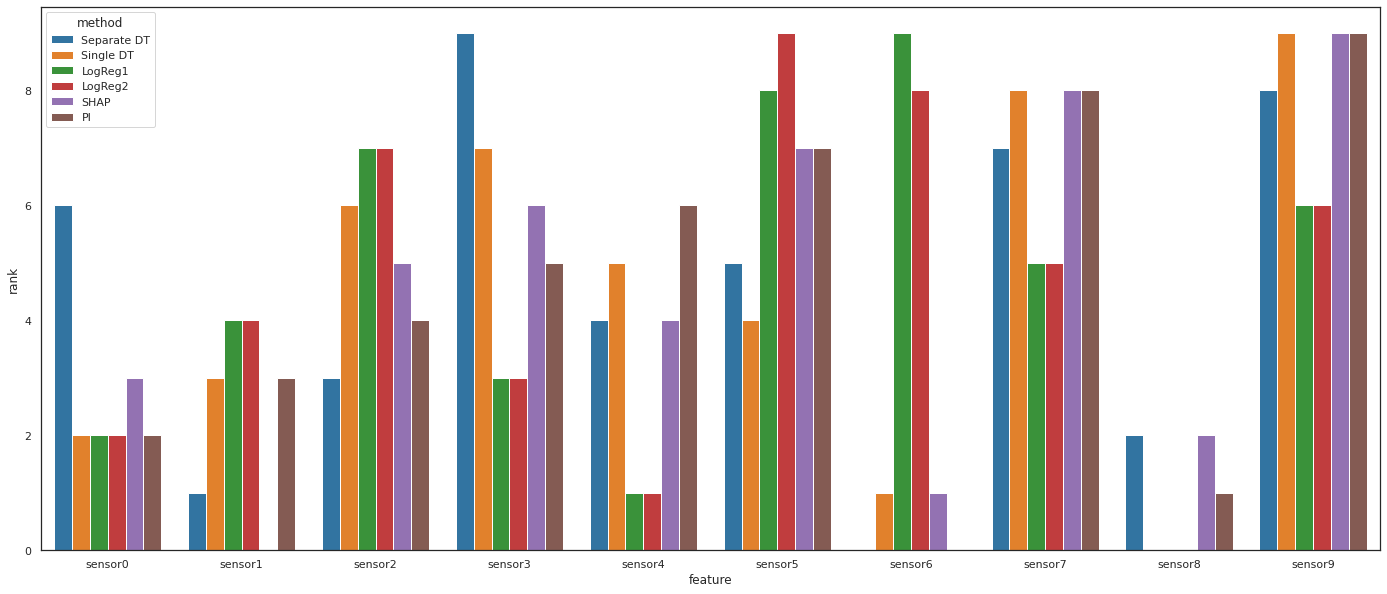

In [77]:
### visualize the ranks for each fetaure
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})
sns.barplot(x='feature', y='rank', hue='method', data=all_feature_ranks);

## Final rank for each sensor

We have 5 methods for ranking our sensors

What we can do is assign weights to them and take a weighted rank to come up with the final rank of the features

In [78]:
method_names

['Separate DT', 'Single DT', 'LogReg1', 'LogReg2', 'SHAP', 'PI']

Here we have assigned weight based on the accuracy of the underlying model used

For example to compute SHAP and Permutaion imp based ranking, we used a DT of max_depth=5 that had accuracy of 99.5%, so the weight for these is 0.995


In [96]:
weights_method = [1, 1, 0.935, 0.9475, 0.995, 0.995]

So for each feature we will compute:

```
feature_rank = sum_for_all_methods(rank_method_i * wt_method_i)/sum_of_wts_of_all_methods
```

In [99]:
def get_normalized_wts(weights_method):
    new_wts = []
    sum_wts = sum(weights_method)
    for idx in range(len(weights_method)):
        wt_ = (sum_wts - weights_method[idx])/sum_wts
        wt_ = wt_/(len(weights_method)-1)

        new_wts.append(wt_)

    print (new_wts)
    print (sum(new_wts))
get_normalized_wts(weights_method)

[0.16594295444870158, 0.16594295444870158, 0.16815666240953595, 0.16773094934014474, 0.16611323967645805, 0.16611323967645805]
1.0


In [116]:
(1*.8 +5*.3 + 7*.3)/1.4

3.1428571428571432

In [115]:
(1*.9 +5*.3 + 7*.3)/1.5

3.0

In [114]:
np.average(a=[1,5,7], weights=[.9,.3,.3])

3.0

In [87]:
all_feature_ranks.groupby('feature', as_index=False).aggregate({'rank': 'mean'}).sort_values(by='feature')

,feature,rank
0,sensor0,2.833333
1,sensor1,2.500000
2,sensor2,5.333333
3,sensor3,5.500000
4,sensor4,3.500000
5,sensor5,6.666667
6,sensor6,3.166667
7,sensor7,6.833333
8,sensor8,0.833333
9,sensor9,7.833333


In [91]:
def compute_average_ranks(all_feature_ranks):
    """
    Compute the average rank of each feature and return the final list
    """
    data = {
        'fetaure': [],
        'final rank': []
    }
    ### GROUP BY feature and take mean(rank) adn SORT BY feature
    average_ranks_for_each_fetaure = all_feature_ranks.groupby('feature', as_index=False).aggregate({'rank': 'mean'}).sort_values(by='feature')
    rank_indices = np.argsort(average_ranks_for_each_fetaure['rank'])

    final_ranks = [f'sensor{i}' for i in rank_indices]
    return final_ranks

final_ranks = compute_average_ranks(all_feature_ranks)


In [92]:
final_ranks

['sensor8',
 'sensor1',
 'sensor0',
 'sensor6',
 'sensor4',
 'sensor2',
 'sensor3',
 'sensor5',
 'sensor7',
 'sensor9']

In [113]:
all_feature_ranks

,feature,rank,method
0,sensor0,6,Separate DT
1,sensor1,1,Separate DT
2,sensor2,3,Separate DT
3,sensor3,9,Separate DT
4,sensor4,4,Separate DT
5,sensor5,5,Separate DT
6,sensor6,0,Separate DT
7,sensor7,7,Separate DT
8,sensor8,2,Separate DT
9,sensor9,8,Separate DT


In [ ]:
def compute_weighted_ranks(all_feature_ranks, method_names, weights_method):
    """
    """

    for fea_ in list(all_feature_ranks['feature'].unique()):
        ### extract the wts
        